In [1]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import random
from collections import Counter 
import statistics
import time

In [2]:
dataset = pd.read_csv('wikigraph_reduced.csv', sep='\t', 
                      delimiter=None, header='infer',
                      names=None, index_col=None, 
                      usecols=None, 
                      encoding = "ISO-8859-1")
dataset.head()

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [3]:
dataset.columns=['Index','Source','Target']

In [4]:
# check if index columns has unique values
print(len(dataset.Index))
print(len(set(dataset.Index)))

483094
483094


In [5]:
dataset.set_index('Index' , inplace = True)
dataset.head()

,Source,Target
Index,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


#### Associate single category to each node

In [6]:
# all nodes in and out
unique_nodes = set(set(dataset.Source).union(set(dataset.Target)))
n_nodes = len(unique_nodes)
n_edges = len(dataset)

In [7]:
category_file = 'wiki-topcats-categories.txt'

In [8]:
categories = {v: [] for v in unique_nodes}
categories_to_nodes = {} # mantiene la struttura originale del file catgoria -> nodi
lost = []

with open(category_file) as file:
    for i in range(17364):
        line = file.readline()
        category = line.split(';')[0].split(':')[-1]
        nodes = line.split(';')[1].split(' ')[1:-2]
        existing_nodes = []
        
        for node in nodes:
            try:
                categories[int(node)].append(category)
            except:
                lost.append(int(node))
            
            if int(node) in unique_nodes:
                existing_nodes.append(node)
        
        if existing_nodes != []:    
            categories_to_nodes[category] = existing_nodes


In [9]:
categories_filtered = {}
for n in categories.keys():
    try:
        rand_category = random.choice(categories[n])
        categories_filtered[n] = rand_category
    except:
        categories_filtered[n] = None

#### Create graph

In [10]:
in_links = {v: [] for v in set(dataset.Source)}
out_links = {v: [] for v in set(dataset.Target)}

for row in dataset.iterrows():
    source = row[1][0]
    target = row[1][1]
    in_links[source].append(target)
    out_links[target].append(source)

In [11]:
# undirected version of the graph
links = in_links.copy()
links.update(out_links)

98343

In [12]:
n_art_outlink = len(out_links)
n_art_inlink = len(in_links)

#### Check if directed

In [13]:
directed = False
for node in in_links:
    if len(set(in_links[node]).intersection(set(out_links[node]))) != 0:
        directed = True
        break
if directed:
    print('Graph is directed')
else:
    print('Graph is undirected')

Graph is directed


#### Density

In [51]:
density = (n_edges/(n_nodes*(n_nodes-1)))
avarage = n_edges/n_nodes

print('Graph density is:',density)
print('Graph hyperliks avarage is:',avarage)

Graph density is: 4.9951571365597335e-05
Graph hyperliks avarage is: 4.912337431235573


#### Visualize the nodes' degree distribution

In [16]:
my_len = [] 
for node in links.keys():
    my_len.append(len(links[node]))

# dictionary with degree
node_degree = dict(zip(links.keys(), my_len))
d = Counter(node_degree)

In [17]:
# degree distribution
counter_supp = list()
for i in range(1, max(my_len)):
    counter_supp.append(my_len.count(i))

In [18]:
# cumulative degree ditribution
counter = [0]
for i in range(1, max(my_len)):
    counter.append(counter[-1]+my_len.count(i))

In [19]:
len(counter)

10815

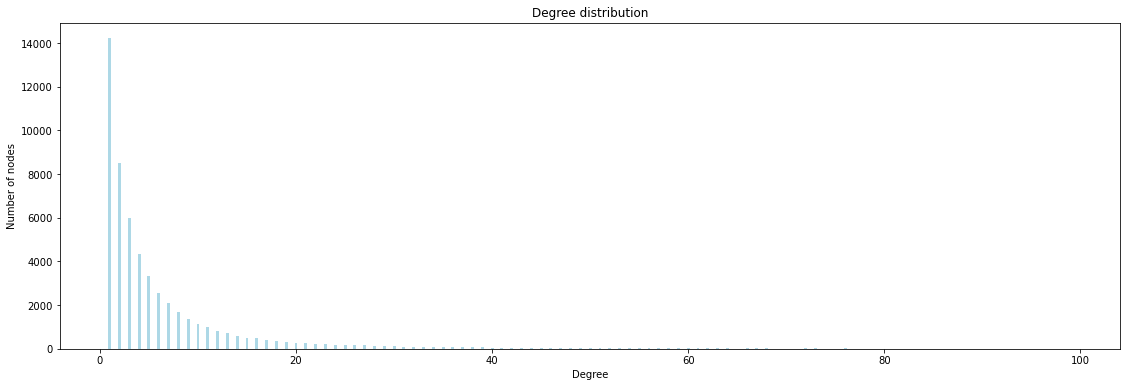

In [20]:
plt.figure(figsize = (19,6))
plt.bar(x = list(range(1,len(counter_supp[1:100])+1)),height = counter_supp[1:100],color = 'lightblue',width = 0.3);
#plt.plot(counter[1:100],color = 'lightblue');
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Degree distribution')
plt.show()

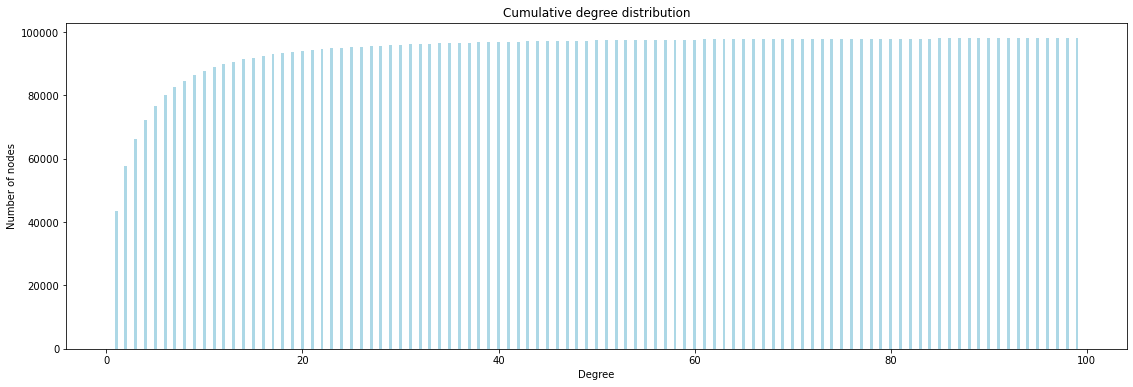

In [21]:
plt.figure(figsize = (19,6))
plt.bar(x = list(range(1,len(counter[1:100])+1)),height = counter[1:100],color = 'lightblue',width = 0.3);
#plt.plot(counter[1:100],color = 'lightblue');
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Cumulative degree distribution')
plt.show()

### Useful Functions

In [22]:
def shortest_path (node1,node2):
    
    ''' This function takes in input two nodes and returns the length of the shortest path.
    If node 1 does not have any outlink or if no path is found between node 1 and node 2, None is returned. '''
    
    # exeptions
    if node1 == node2:
        return 0
    
    # set of outnodes of node 1
    try:
        out_nodes = set(out_links[node1]) 
    except:
        print('No out-link from', node1)
        return None
    
    # initializing explored nodes set and minimu distance
    explored = set() 
    clicks = 1
    
    # 1. we iterate until we don't find node 2 
    # 2. we check the new set of out-nodes to explore is non-empty 
    # 3. we iterate through unexplored nodes
    # 4. if the node is a key in out_links, we add the set of nodes associated to it to the new set of nodes
    while node2 not in out_nodes: 
        
        if out_nodes != set(): 
            new_out_nodes = set() 

            for node in out_nodes:  
                try:
                    new_out_nodes = new_out_nodes.union(set(out_links[node]))
                except:
                    continue
            
            # update
            explored = explored.union(out_nodes)
            out_nodes = new_out_nodes.difference(explored) 
            clicks += 1 
        
        # case in which we have not found node 2 but we don't have any other node to explore
        else: 
            print('No path found')
            return None
    
    return clicks

In [96]:
def explore(node,limit):
   
    ''' This function takes as an input one node and a click limit.
    Limit can be set to None if we don't want any limit.
    The function returns a dictionary where keys are distances and values are all the nodes 
    which are at distance d (key) from the input node'''
    
    # initializing variables
    distance_tree = {}
    explored = set()
    clicks = 1 
    
    # checking if node has at list one outlink
    try:
        out_nodes = set(out_links[node]) # set of outnodes of node 1
    except:
        print('No out-link from', node)
        return distance_tree
    
    # 1. We iterate until the new set of out-nodes to explore is non-empty 
    # 2. For each iteration we only consider unexplored nodes
    # 3. If the node is a key in out_links, we add the set of nodes associated to it to the new set of nodes
    # 4. We update all variables and increase distance by one
    while out_nodes != set(): 
        
        # We return when limit is given and reached
        if limit != None:
            if clicks > limit+1:
                return distance_tree
        
        distance_tree[clicks] = out_nodes
        new_out_nodes = set() 
        
        for node in out_nodes: 
            
            try:
                new_out_nodes = new_out_nodes.union(set(out_links[node])) 
            except:
                continue
        
        explored = explored.union(out_nodes) 
        out_nodes = new_out_nodes.difference(explored)
        clicks += 1 
    
    return distance_tree

In [97]:
node1 = 108
node2 = 1161925
node3 = 134

In [67]:
# esempi di shortest_path
print('The shortest path between', node3, 'and', node1, 'is', shortest_path(node3,node1))

5


In [98]:
# esempio di explore
n_clicks = 4
tree = explore(node3,n_clicks)
print('Exploration tree of node', node3, 'in', n_clicks,'clicks :')
print(tree)

Exploration tree of node 134 in 4 clicks :
{1: {1165126, 1163783, 1061485, 1163610, 1266493}, 2: {1265674, 1060877, 1062926, 1057809, 1266708, 1060885, 1057825, 1058857, 1163306, 771113, 1508396, 1058860, 1163311, 1070137, 1062972, 1246273, 1786953, 761934, 1712209, 1059923, 1166421, 1151062, 1074268, 1264733, 358492, 1066078, 1063007, 1266787, 1161316, 1056873, 1056874, 930923, 1265772, 1557615, 1266804, 1165429, 636021, 1165432, 1165437, 1074304, 134, 1245325, 1299601, 1496212, 1068182, 217240, 1506456, 1266844, 1062045, 1162401, 1213613, 62637, 1163443, 1165498, 530621, 1151170, 1151171, 1056964, 1056965, 1056966, 1163462, 1075400, 1622212, 1056970, 1265868, 1246413, 1246415, 1165520, 1246417, 1557713, 768211, 1246419, 1169619, 1161428, 1163479, 1557720, 1165529, 1169626, 1469659, 1469661, 1163486, 1469662, 1062109, 1062113, 1163490, 1265891, 1469671, 1058023, 1053929, 1264875, 1063149, 1246446, 1058032, 1058035, 1060084, 1162486, 1053949, 1162493, 1058047, 1163520, 1163522, 1166598

## RQ2

In [85]:
def get_articles(node,n_clicks):
    tree = explore(node_id,n_clicks)
    articles = []
    for d in tree.keys():
        articles+=tree[d]
    return articles

In [86]:
start = time.time()
n_clicks = 4
node_id = 134
articles = get_articles(node_id,n_clicks)
print('Execution time: ', (time.time() - start)/60, 'minutes')
print('Number of articles reached within', n_clicks, 'from node', node_id,':', len(articles))

Execution time:  0.26335482597351073 minutes
Number of articles reached within 4 from node 134 : 28129


In [87]:
# per vedere in che modo cresce il numero di articoli 
graph = []
for n_clicks in range(7):
    graph.append(len(get_articles(node_id,n_clicks)))

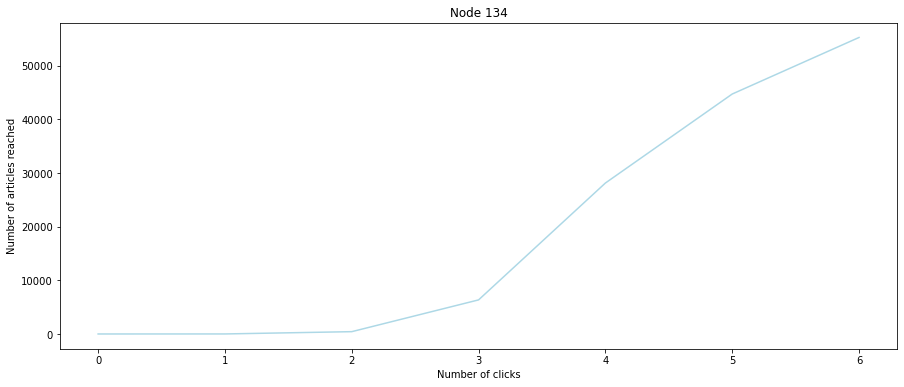

In [92]:
plt.figure(figsize = (15,6))
plt.plot(graph,color = 'lightblue');
plt.ylabel('Number of articles reached')
plt.xlabel('Number of clicks')
plt.title(f'Node {node_id}')
plt.show()

## RQ5

In [103]:
def categories_distance(c1):
    
    
    # list of nodes in category one and two
    # in casting needed for comparison porpuses
    categories = categories_to_nodes.keys()
    c1_nodes = [int(i) for i in categories_to_nodes[c1]]
    distances_dict = {}
  
    # we iterate all nodes in category one and build an exploration tree
    # for each tree we iterate all distances (keys of distance_tree) and we add to distance
    # the occurrence of nodes of c2 times the distance in that iteration
    for node1 in c1_nodes:
        distance_tree = explore(node1,None)
        for cat in categories:
            dist = []
            
            for d in distance_tree.keys():
                c2_nodes = [int(i) for i in categories_to_nodes[cat]]
                n_nodes = len(set(c2_nodes).intersection(set(distance_tree[d])))
                dist += [d]*n_nodes
        
            # check if at list one path exists
            if dist != []:
                distances_dict[cat] = statistics.median(dist)
    
    distances_dict = {k: v for k, v in sorted(distances_dict.items(), key=lambda item: item[1])}
    
    return distances_dict

In [104]:
c1 = 'English_philosophers'
start = time.time()
d = categories_distance(c1)
print('Execution time:', (time.time() - start)/60, 'minutes')

No out-link from 65934
No out-link from 66612
No out-link from 245917
Execution time: 1.66797034740448 minutes


In [105]:
d

{'Members_of_the_pre-1707_Parliament_of_England': 1,
 'People_of_the_Tudor_period': 1.5,
 '16th-century_English_people': 1.5,
 'Year_of_birth_missing': 1.5,
 'Marxist_theorists': 2,
 'University_of_Freiburg_alumni': 2,
 'People_from_the_Province_of_Brandenburg': 2,
 'English_theologians': 2,
 'Chess_grandmasters': 2,
 'English_writers': 2,
 '16th-century_writers': 2,
 'English_knights': 2,
 'Jews_in_Ottoman_and_British_Palestine': 3,
 'History_of_Israel': 3,
 'Recipients_of_the_Mdaille_Militaire': 3,
 'Hockey_Hall_of_Fame_inductees': 3,
 'History_of_telecommunications': 3,
 'Adirondacks': 3,
 'British_Empire': 3,
 'Olympic_fencers_of_Great_Britain': 3,
 'Order_of_the_Crown_(Belgium)_recipients': 3,
 'British_biographers': 3,
 'Scottish_Presbyterians': 3.0,
 'Members_of_the_Order_of_Merit': 3.0,
 'Little,_Brown_and_Company_books': 3,
 'British_ornithologists': 3,
 'Canadian_Football_Hall_of_Fame_inductees': 3,
 'Olympic_medalists_in_sailing': 3,
 'Knights_of_the_Elephant': 3,
 'De_Burgh